### DATE: 7th March, 2025
### NAME: P.SATYA PREM
### PRN: 22070126073
### AIML-A3

### OBJECTIVE:
The goal of this assignment is to implement a Deep Convolutional Generative Adversarial Network (DCGAN) as described in the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" by Radford et al. (2015).

You will train the model on either the LSUN Bedrooms dataset or the CelebA Faces dataset to generate realistic images.

Selected dataset: CelebA


### THEORY:
A Deep Convolutional Generative Adversarial Network (DCGAN) is a class of GANs introduced by Radford et al. (2015) that incorporates deep convolutional layers to improve image generation quality and training stability. It consists of two neural networks: a generator and a discriminator, both utilizing convolutional layers instead of fully connected layers as in traditional GANs. The generator takes random noise as input and transforms it into realistic-looking images through a series of transposed convolutional layers, batch normalization, and ReLU activations. The discriminator, a convolutional neural network (CNN), distinguishes real images from generated ones using LeakyReLU activations and batch normalization. DCGAN employs key architectural improvements such as replacing pooling layers with strided convolutions, removing fully connected layers in the generator, and using batch normalization to stabilize training. It has been widely used for generating high-quality images in domains like facial synthesis, artistic creation, and data augmentation.

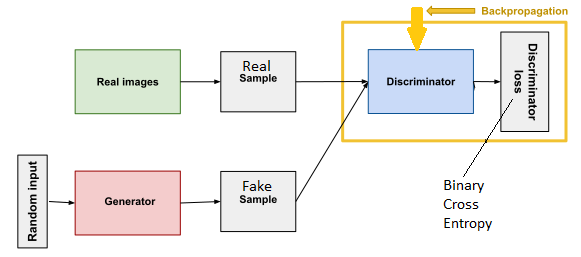

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm #Progress Bar
import torchvision.utils as vutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/GANL/img_align_celeba.zip" -d /content/celeba/


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Defining transformations
transform = transforms.Compose([
    transforms.Resize(64),  # Resize to 64x64
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

# Loading images
dataset = datasets.ImageFolder(root="/content/celeba/", transform=transform)

# Creating DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


# Checking dataset size
print(f"Dataset Size: {len(dataset)} images")

Dataset Size: 202599 images


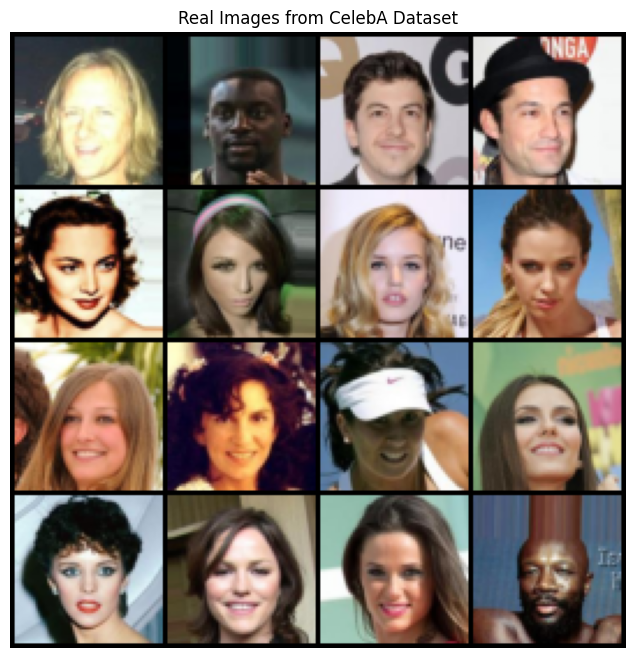

In [ ]:
# Function to display real images
def show_real_images(dataloader, num_images=16):
    real_batch = next(iter(dataloader))
    images = real_batch[0][:num_images]  # Get first batch
    images = images * 0.5 + 0.5  # Unnormalize to [0,1] range
    grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Real Images from CelebA Dataset")
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Showing real images
show_real_images(dataloader)

In [ ]:
# Defining Generator class
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
# Defining Discriminator class
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Initializing models
nz = 100  # Latent vector size
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
nc = 3  # Number of color channels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(nz, ngf, nc).to(device)
discriminator = Discriminator(nc, ndf).to(device)


In [ ]:
# Defining loss function and optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 10
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
for epoch in range(num_epochs):
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as t:
        for i, (data, _) in enumerate(t):
            real_images = data.to(device)
            batch_size = real_images.size(0)
            label_real = torch.full((batch_size,), 1.0, device=device)
            label_fake = torch.full((batch_size,), 0.0, device=device)

            # Train Discriminator
            optimizerD.zero_grad()
            output_real = discriminator(real_images).view(-1)
            loss_real = criterion(output_real, label_real)
            loss_real.backward()

            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach()).view(-1)
            loss_fake = criterion(output_fake, label_fake)
            loss_fake.backward()
            optimizerD.step()

            # Train Generator
            optimizerG.zero_grad()
            output_fake = discriminator(fake_images).view(-1)
            loss_G = criterion(output_fake, label_real)
            loss_G.backward()
            optimizerG.step()

            t.set_postfix(loss_D=(loss_real+loss_fake).item(), loss_G=loss_G.item())

    # Save generated images every 5 epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            fake_images = generator(fixed_noise).detach().cpu()
        vutils.save_image(fake_images, f"generated_epoch_{epoch+1}.png", normalize=True)



Epoch 10/10: 100%|██████████| 1583/1583 [04:40<00:00,  5.65it/s, loss_D=0.112, loss_G=4.32]


### CONCLUSION:
  
In this experiment, we successfully implemented a **Deep Convolutional Generative Adversarial Network (DCGAN)** based on Radford et al. (2015) to generate realistic face images from the **CelebA dataset**. The generator and discriminator were trained using adversarial loss, with the generator improving over time to produce high-quality images. The model effectively learned meaningful facial features, as seen in the generated samples. However, further fine-tuning, hyperparameter optimization, and longer training could enhance the realism and diversity of the outputs. Overall, this experiment demonstrates the power of GANs in realistic image synthesis.